<a href="https://colab.research.google.com/github/Ulises-Zamarripa/plant-disease-detection/blob/main/Potato_%26_Tomato_Disease_Identification_Ulises_Z.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch --upgrade
!pip install torchvision --upgrade

In [ ]:
# @title
import kagglehub

# Correct dataset handle
path = kagglehub.dataset_download("arjuntejaswi/plant-village")

print("Downloaded to:", path)

import os, sys
from contextlib import redirect_stderr
import io

Using Colab cache for faster access to the 'plant-village' dataset.
Downloaded to: /kaggle/input/plant-village


In [ ]:
import os
os.environ["OPENBLAS_VERBOSE"] = "0"
# to supress openblas warnings


import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# The base directory that contains the folders you listed
BASE_DIR = path + "/PlantVillage"
IMG_SIZE = 64

selected_classes = [
    "Potato___Early_blight",
    "Potato___Late_blight",
    "Potato___healthy",
    "Tomato__Tomato_mosaic_virus",
    "Tomato__Tomato_YellowLeaf__Curl_Virus",
    "Tomato_healthy"
]

images = []
labels = []

class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}

for cls in selected_classes:
    folder = os.path.join(BASE_DIR, cls)
    print("Loading:", folder)

    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        images.append(img)
        labels.append(class_to_idx[cls])

images = np.array(images)
labels = np.array(labels)

print("Loaded images:", images.shape)
print("Loaded labels:", labels.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

print("Train:", X_train.shape)
print("Test:", X_test.shape)

Loading: /kaggle/input/plant-village/PlantVillage/Potato___Early_blight
Loading: /kaggle/input/plant-village/PlantVillage/Potato___Late_blight
Loading: /kaggle/input/plant-village/PlantVillage/Potato___healthy
Loading: /kaggle/input/plant-village/PlantVillage/Tomato__Tomato_mosaic_virus
Loading: /kaggle/input/plant-village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus
Loading: /kaggle/input/plant-village/PlantVillage/Tomato_healthy
Loaded images: (7324, 64, 64, 3)
Loaded labels: (7324,)
Train: (5859, 64, 64, 3)
Test: (1465, 64, 64, 3)


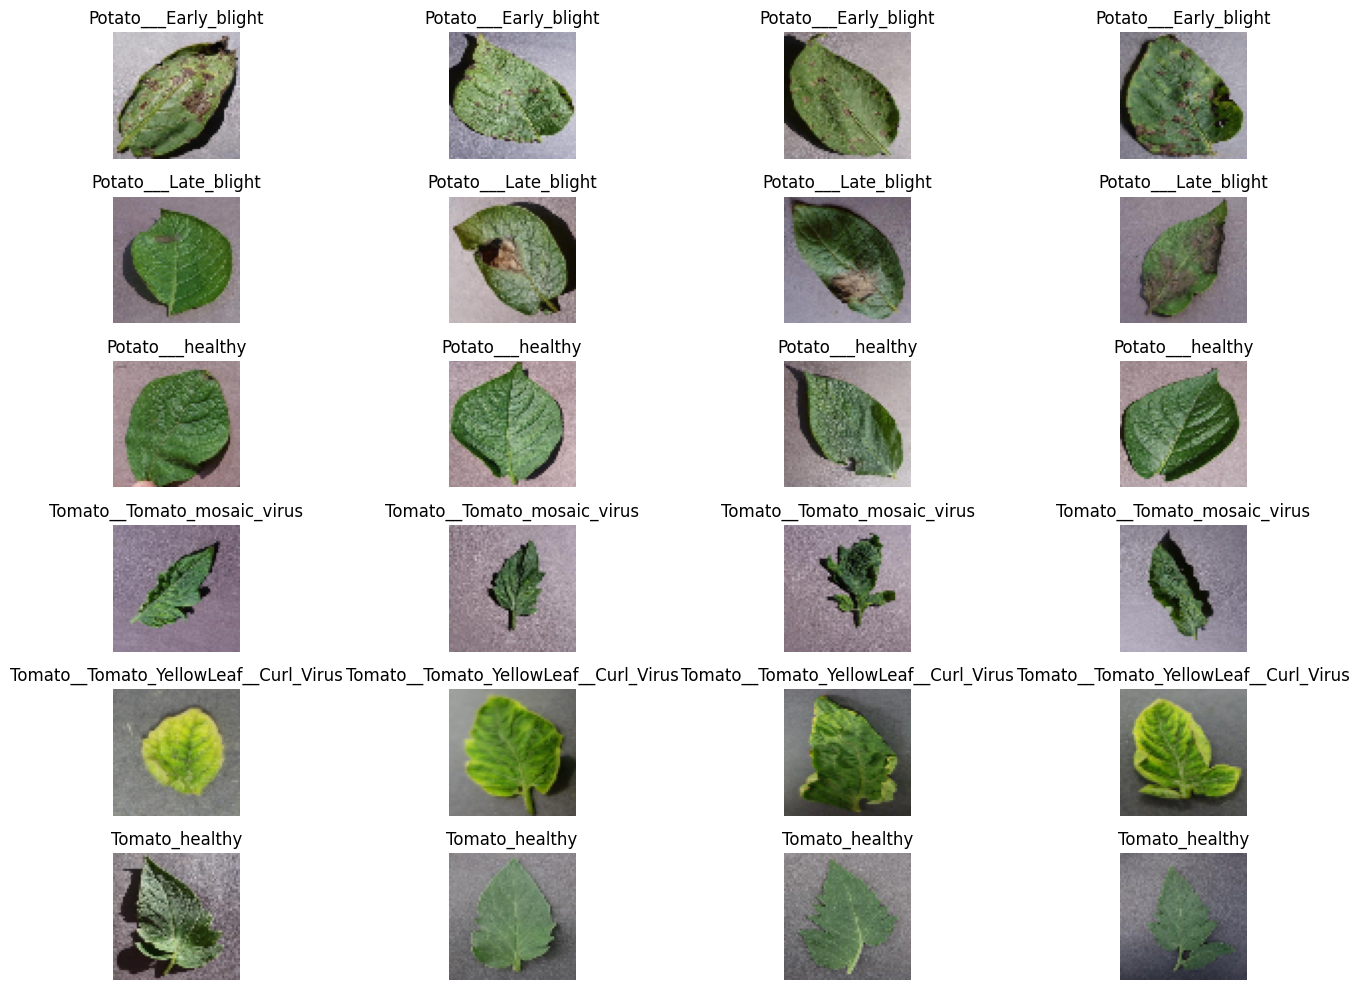

In [ ]:
import matplotlib.pyplot as plt

def show_samples_per_class(X, y, class_names, samples=4):
    plt.figure(figsize=(15, 10))

    for idx, cls in enumerate(class_names):
        cls_idx = class_to_idx[cls]
        cls_images = X[y == cls_idx]

        for i in range(samples):
            plt.subplot(len(class_names), samples, idx * samples + i + 1)
            plt.imshow(cv2.cvtColor(cls_images[i], cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(cls)

    plt.tight_layout()
    plt.show()

show_samples_per_class(images, labels, selected_classes, samples=4)

In [ ]:
# Flatten images for KNN
X_train_knn = X_train.reshape(len(X_train), -1) / 255.0
X_test_knn  = X_test.reshape(len(X_test), -1) / 255.0

print("KNN train shape:", X_train_knn.shape)
print("KNN test shape:", X_test_knn.shape)


KNN train shape: (5859, 12288)
KNN test shape: (1465, 12288)


In [ ]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

knn = KNeighborsClassifier(n_neighbors=3, algorithm="kd_tree")
knn.fit(X_train_knn, y_train)

y_pred_knn = knn.predict(X_test_knn)

acc_knn = accuracy_score(y_test, y_pred_knn)
print("🔵 KNN Accuracy:", acc_knn)

🔵 KNN Accuracy: 0.783617747440273


In [ ]:
print("\nClassification Report (KNN):\n")
print(classification_report(y_test, y_pred_knn, target_names=selected_classes))


Classification Report (KNN):

                                       precision    recall  f1-score   support

                Potato___Early_blight       0.97      0.36      0.53       200
                 Potato___Late_blight       0.52      0.87      0.65       200
                     Potato___healthy       0.69      0.30      0.42        30
          Tomato__Tomato_mosaic_virus       0.96      0.33      0.50        75
Tomato__Tomato_YellowLeaf__Curl_Virus       0.88      0.96      0.92       642
                       Tomato_healthy       0.79      0.79      0.79       318

                             accuracy                           0.78      1465
                            macro avg       0.80      0.60      0.63      1465
                         weighted avg       0.82      0.78      0.77      1465



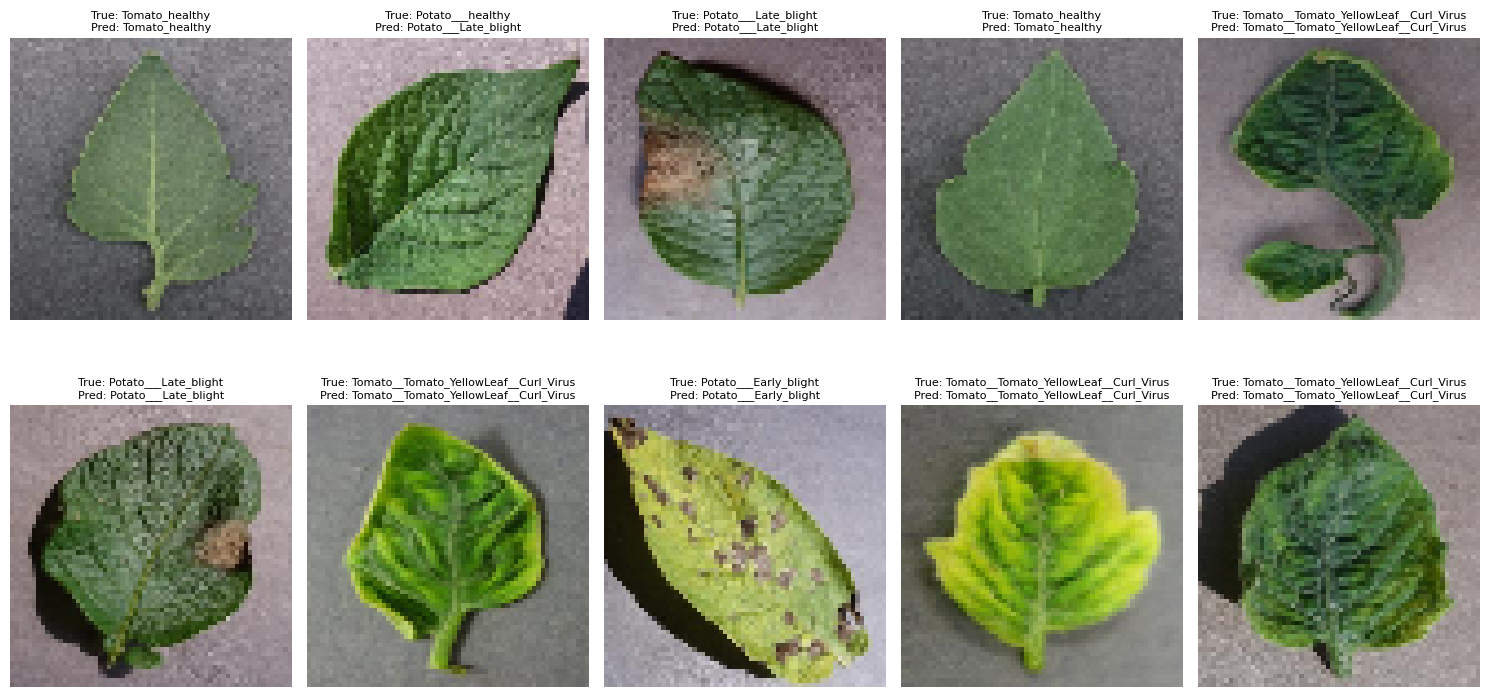

In [ ]:
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))

for i in range(10):
    idx = random.randint(0, len(X_test)-1)

    img = X_test[idx]
    img_flat = img.reshape(1, -1) / 255.0

    pred = knn.predict(img_flat)[0]
    true = y_test[idx]

    plt.subplot(2, 5, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"True: {selected_classes[true]}\nPred: {selected_classes[pred]}", fontsize=8)

plt.tight_layout()
plt.show()